In [1]:
pip install pyvis

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import packages. Run this cell.
import numpy as np
import numpy.random as rn
from numpy.core.fromnumeric import shape
from pyvis import network as net
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import torch.optim as optim
from matplotlib import pyplot as plt

In [3]:
"""
Define the environment
"""

class Gridworld(object):
    """
    Topology MDP.
    """

    def __init__(self, reward_list, discount = 0.95):
        """
        Topology G(9, 16)
        """
        g = net.Network(height='400px', width='50%', heading='')
        self.reward_list = reward_list # Reward list
        self.n_states = 9 # number of states
        # Build the network
        for i in range(self.n_states):
            g.add_node(i)
        g.add_edge(0,1)
        g.add_edge(1,2)
        g.add_edge(2,3)
        g.add_edge(3,0)
        g.add_edge(4,5)
        g.add_edge(5,6)
        g.add_edge(6,7)
        g.add_edge(7,8)
        g.add_edge(4,7)
        g.add_edge(0,4)
        g.add_edge(1,5)
        g.add_edge(2,6)
        g.add_edge(3,7)
        g.add_edge(4,8)
        g.add_edge(5,8)
        g.add_edge(6,8)
        g.add_edge(7,8)
        self.n_arcs = len(g.edges) # num of arcs 16
        self.arcs = g.edges
        self.neighbor_map = g.get_adj_list()
        self.from_set = []
        self.to_set = []
        for j in range(self.n_arcs):
            self.from_set.append(g.edges[j]['from'])
        for j in range(self.n_arcs):
            self.to_set.append(g.edges[j]['to'])
        self.from_set = np.array(self.from_set)
        self.to_set = np.array(self.to_set)
        self.discount = discount

    def state_transition_func(self, state, action):
        """
        Map (current pos and next pos) to the arc
        """
        next = list(self.neighbor_map[state])[action]
        return next

    def reset(max_num):
        """
        New aircraft comes in
        """
        state = np.random.randint(0,max_num,[9,9])
        np.fill_diagonal(state, 0)
        return state

    def canonical_arc(self, cur, next):
        """
        With current and next steps, find the corresponding arc
        """
        # if cur in the from set
        arc_idx = -1
        
        if next in self.from_set[np.where(self.to_set==cur)]:
            arc_idx = np.intersect1d(np.where(self.to_set==cur), np.where(self.from_set==next))
        else:
            arc_idx = np.intersect1d(np.where(self.to_set==next), np.where(self.from_set==cur))
            
        # if self.from_set[self.to_set.index(cur)] == next:
        #     arc_idx = self.to_set.index(cur)
        #     print(arc_idx)
        # elif self.to_set[self.from_set.index(cur)] == next:
        #     arc_idx = self.from_set.index(cur)
        # else:
        #     arc_idx = self.from_set.index(cur)        
        return arc_idx.squeeze()     

    def step(self, state, action, terminal_state):
        arc_idx = 0
        next_state = self.state_transition_func(state, action)
        arc_idx = self.canonical_arc(state, next_state)     
        reward = self.reward_list[arc_idx]
        if state == terminal_state:
            done = True
        else:
            done = False
        return next_state, reward, done


    def value_iteration(self, des):
        """
        Please use value iteration to compute the optimal value function and store it into the vector V with size 64
        For example, V[0] means the optimal value function for state 0.
        """
        V = np.zeros((9,))
        V_old = np.zeros((9,))
        ### BEGIN SOLUTION
        # YOUR CODE HERE
        flag = 1
        while flag:
          for state in range(9):
            if(state == des):
              V[state] = 0
              continue
            list = []

            if state ==0 or state == 1 or state == 2 or state ==3:
                  for action in range(3):  
                    next_state, reward, done = self.step(state, action, terminal_state = des)
                    list.append(self.discount * V_old[next_state] + (reward-1))
                  V[state] = max(list) 
            else:

                  for action in range(4):
                    next_state, reward, done = self.step(state, action, terminal_state = des)
                    list.append(self.discount * V_old[next_state] + (reward-1))
                  V[state] = max(list) 

          # print(V)
          V_change = np.subtract(V, V_old)
          # print(V_old)
          V_change = abs(V_change)
          if np.max(V_change) < 0.1:
            flag = 0

          V_old = np.copy(V)
        ### END SOLUTION
        return V
    
    def value_itr(self):
        V = np.zeros([9,9])
        for i in range(9):
            V[i] = np.array(self.value_iteration(i))
        return V


    def evaluate(self, agent, v):
      evaluate = np.zeros((16,))
      #print('agent',agent,v)
      for a in agent:
        value = v[int(a[1])]
        list = []
        if a[0] == 0 or a[0] == 1 or a[0] == 2 or a[0] == 3 :
            max = -np.inf
            for action in range(3):
              next_state = self.state_transition_func(a[0], action)
              if value[next_state] > max:
                max = value[next_state]
                next_state_0 = next_state
            evaluate[self.canonical_arc(a[0], next_state_0)] += 1
            a[0] = next_state_0
        else:
            max = -np.inf
            for action in range(4):
              next_state = self.state_transition_func(a[0], action)
              if value[next_state] > max:
                next_state_0 = next_state
            evaluate[self.canonical_arc(a[0], next_state)] += 1
            a[0] = next_state_0
      return evaluate,agent

    def score_fun(self,evaluate):
      score = 0
      score = -0.1 * np.sum((self.reward_list) * evaluate) - np.sum(np.maximum(evaluate - np.ones(16),np.zeros(16)))
      return score

    def from_agent_to_config(self,agent):
      config = np.zeros([9,9])
      for a in agent:
        config[a[1],a[0]] += 1
        config = self.clean_config(config)
      return config

    def from_config_to_agent(self,config):
      agent = []
      config = self.clean_config(config)
      config = config.reshape([9,9])
      for i in range(9):
        for j in range(9):
          while config[i,j] != 0:
            agent.append([j,i])
            config[i,j] -= 1
      return agent
    
    def clean_config(self,config):
      if len(config.shape) == 1:
        config = config.reshape([9,9])
      np.fill_diagonal(config, 0)
      return config

    def config_step(self,config):
      V = self.value_itr()
      config = self.clean_config(config)
      agent = self.from_config_to_agent(config)
      evaluate,agent = self.evaluate(agent,V)
      next_config = self.from_agent_to_config(agent)
      next_config = self.clean_config(next_config)
      score = self.score_fun(evaluate)
      return next_config,score

    def add_random_des():
      return

In [4]:
"""
Some parameters
"""
state_size = 9*9  # state dimension
action_size = 16  # action dimension
fc_units = 256  # number of neurons in one fully connected hidden layer
action_upper_bound = 1  # action space upper bound
action_lower_bound = -1  # action space lower bound


"""
Structure of Actor Network.
"""
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_action = action_upper_bound
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc_units)
        self.fc3 = nn.Linear(fc_units, action_size)

    def forward(self, state):
        """
        Build an actor (policy) network that maps states -> actions.
        Args:
            state: torch.Tensor with shape (batch_size, state_size)
        Returns:
            action: torch.Tensor with shape (batch_size, action_size)
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = torch.tanh(self.fc3(x)) * self.max_action
        return action


"""
Structure of Critic Network.
"""
class CriticQ(nn.Module):
    def __init__(self):
        """
        Args:
            state_size: state dimension
            action_size: action dimension
            fc_units: number of neurons in one fully connected hidden layer
        """
        super().__init__()
        
        # Q-network 1 architecture
        self.l1 = nn.Linear(state_size + action_size, fc_units)
        self.l2 = nn.Linear(fc_units, fc_units)
        self.l3 = nn.Linear(fc_units, 1)

        # Q-network 2 architecture
        self.l4 = nn.Linear(state_size + action_size, fc_units)
        self.l5 = nn.Linear(fc_units, fc_units)
        self.l6 = nn.Linear(fc_units, 1)

    def forward(self, state, action):
        """
        Build a critic (value) network that maps state-action pairs -> Q-values.
        Args:
            state: torch.Tensor with shape (batch_size, state_size)
            action: torch.Tensor with shape (batch_size, action_size)
        Returns:
            Q_value_1: torch.Tensor with shape (batch_size, 1)
            Q_value_2: torch.Tensor with shape (batch_size, 1)
        """
        state_action = torch.cat([state, action], 1)
        
        x1 = F.relu(self.l1(state_action))
        x1 = F.relu(self.l2(x1))
        Q_value_1 = self.l3(x1)
        
        x2 = F.relu(self.l4(state_action))
        x2 = F.relu(self.l5(x2))
        Q_value_2 = self.l6(x2)
        
        return Q_value_1, Q_value_2

In [5]:
"""
Implementation of TD3 Algorithm
"""
import random
class TD3:
    def __init__(self):
        self.lr_actor = 1e-2  # learning rate for actor network
        self.lr_critic = 1e-2  # learning rate for critic network
        self.buffer_capacity = 100000  # replay buffer capacity
        self.batch_size = 128  # mini-batch size
        self.tau = 0.02  # soft update parameter
        self.policy_delay = 2  # policy will be updated once every policy_delay times for each update of the Q-networks.
        self.gamma = 0.99  # discount factor
        self.target_noise = 0.2  # standard deviation for smoothing noise added to target policy
        self.noise_clip = 0.5  # limit for absolute value of target policy smoothing noise.
        self.update_every = 200  # number of env interactions that should elapse between updates of Q-networks.
        # Note: Regardless of how long you wait between updates, the ratio of env steps to gradient steps should be 1.
        self.state_size = state_size
        self.action_size = action_size
        self.device = torch.device("cpu")  # or self.device = torch.device("cuda")
        self.action_upper_bound = action_upper_bound  # action space upper bound
        self.action_lower_bound = action_lower_bound  # action space lower bound
        self.create_actor()
        self.create_critic()
        self.act_opt = optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        self.crt_opt = optim.Adam(self.critic.parameters(), lr=self.lr_critic)
        self.replay_memory_buffer = deque(maxlen=self.buffer_capacity)
        
    def create_actor(self):
        self.actor = Actor().to(self.device)
        self.actor_target = Actor().to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

    def create_critic(self):
        self.critic = CriticQ().to(self.device)
        self.critic_target = CriticQ().to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())
    
    def add_to_replay_memory(self, state, action, reward, next_state, done):
        """
        Add samples to replay memory
        Args:
            state: current state, a numpy array with shape (state_size,)
            action: current action, a numpy array with shape (action_size,)
            reward: reward obtained
            next_state: next state, a numpy array with shape (state_size,)
            done: True when the current episode ends, False otherwise
        """
        self.replay_memory_buffer.append((state, action, reward, next_state, done))

    def get_random_sample_from_replay_mem(self):
        """
        Random samples from replay memory without replacement
        Returns a self.batch_size length list of unique elements chosen from the replay buffer.
        Returns:
            random_sample: a list with len=self.batch_size,
                           where each element is a tuple (state, action, reward, next_state, done)
        """
        random_sample = random.sample(self.replay_memory_buffer, self.batch_size)
        return random_sample
    
    def soft_update_target(self, local_model, target_model):
        """
        Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Args:
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

    def train(self, cur_time_step, episode_time_step, state, action, reward, next_state, done):
        """
        Collect samples and update actor network and critic network using mini-batches of experience tuples.
        Args:
            cur_time_step: current time step counting from the beginning, 
                           which is equal to the number of times the agent interacts with the environment
            episode_time_step: the time step counting from the current episode
            state: current state, a numpy array with shape (state_size,)
            action: current action, a numpy array with shape (action_size,)
            reward: reward obtained
            next_state: next state, a numpy array with shape (state_size,)
            done: True when the current episode ends, False otherwise
        """
        self.add_to_replay_memory(state, action, reward, next_state, done)      
        if len(self.replay_memory_buffer) < self.batch_size:
            return
        if cur_time_step % self.update_every != 0:
            return
        
        # Perform self.update_every times of updates of the critic networks and 
        # (self.update_every / policy_delay) times of updates of the actor network
        for it in range(self.update_every): 
            """
            state_batch: torch.Tensor with shape (self.batch_size, state_size), a mini-batch of current states
            action_batch: torch.Tensor with shape (self.batch_size, action_size), a mini-batch of current actions
            reward_batch: torch.Tensor with shape (self.batch_size, 1), a mini-batch of rewards
            next_state_batch: torch.Tensor with shape (self.batch_size, state_size), a mini-batch of next states
            done_list: torch.Tensor with shape (self.batch_size, 1), a mini-batch of 0-1 integers, 
                   where 1 means the episode terminates for that sample;
                         0 means the episode does not terminate for that sample.
            """
            mini_batch = self.get_random_sample_from_replay_mem()
            state_batch = torch.from_numpy(np.vstack([i[0] for i in mini_batch])).float().to(self.device)
            action_batch = torch.from_numpy(np.vstack([i[1] for i in mini_batch])).float().to(self.device)
            reward_batch = torch.from_numpy(np.vstack([i[2] for i in mini_batch])).float().to(self.device)
            next_state_batch = torch.from_numpy(np.vstack([i[3] for i in mini_batch])).float().to(self.device)
            done_list = torch.from_numpy(np.vstack([i[4] for i in mini_batch]).astype(np.uint8)).float().to(self.device)
            
            # Please complete codes for updating the critic networks
            """
            Hints: 
              You may use the above tensors: state_batch, action_batch, reward_batch, next_state_batch, done_list
              You may use self.critic_target and self.actor_target as your target networks
              you may use target policy smoothing techniques with hyperparameters self.target_noise and self.noise_clip
              You may use clipped double Q-learning techniques
              You may update self.critic using the optimizer self.crt_opt and MSE loss function.
              Make sure to consider whether the corresponding episode terminates when calculating target values.
                If the episode terminates, then the next state value should be 0.
            """
            ### BEGIN SOLUTION
            # YOUR CODE HERE
            current_q = self.critic(state_batch,action_batch)
            next_action_batch = self.actor_target(next_state_batch) + torch.clamp(torch.normal(0,0.2,action_batch.shape),-self.noise_clip,self.noise_clip)
            target_q1 = reward_batch + torch.mul(torch.mul(self.critic_target(next_state_batch,next_action_batch)[0].detach(),self.gamma),1-done_list)
            target_q2 = reward_batch + torch.mul(torch.mul(self.critic_target(next_state_batch,next_action_batch)[1].detach(),self.gamma),1-done_list)
            
            y = torch.min(target_q1,target_q2)
            loss = ((torch.sum((y - current_q[0])**2) + torch.sum((y - current_q[1])**2))).mean()
            self.crt_opt.zero_grad()
            loss.backward()
            self.crt_opt.step()
            ### END SOLUTION
           
            # Train Actor
            # Delayed policy updates
            # Update self.actor once every policy_delay times for each update of self.critic
            if it % self.policy_delay == 0:
                
                # Please complete codes for updating of the actor network
                """
                Hint: 
                  You may update self.actor using the optimizer self.act_opt and recall the loss function for DDPG training
                """
                ### BEGIN SOLUTION
                # YOUR CODE HERE
                actor = self.actor(state_batch)
                q1,q2 = self.critic(state_batch,actor)
                loss = -sum(q1+q2)
                self.act_opt.zero_grad()
                loss.backward()
                self.act_opt.step()
                ### END SOLUTION
                
                # Soft update target models
                self.soft_update_target(self.critic, self.critic_target)
                self.soft_update_target(self.actor, self.actor_target)
            
    
    def policy(self, state):
        """
        Select action based on the actor network.
        Args:
            state: a numpy array with shape (state_size,)
        Returns:
            actions: a numpy array with shape (action_size,)
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.actor.eval()
        with torch.no_grad():
            actions = np.squeeze(self.actor(state).cpu().data.numpy())
        self.actor.train()
        return actions



In [6]:
def generate_config(num_max):
        state = np.random.randint(0,num_max,[9,9])
        np.fill_diagonal(state, 0)
        return state

Ep. 1, Ep.Timesteps 24, Episode Reward: -750.51Ep. 1, Ep.Timesteps 24, Episode Reward_naive: -736.00
Ep. 2, Ep.Timesteps 24, Episode Reward: -967.08Ep. 2, Ep.Timesteps 24, Episode Reward_naive: -951.00
Ep. 3, Ep.Timesteps 24, Episode Reward: -893.66Ep. 3, Ep.Timesteps 24, Episode Reward_naive: -870.00
Ep. 4, Ep.Timesteps 24, Episode Reward: -1027.11Ep. 4, Ep.Timesteps 24, Episode Reward_naive: -1005.00
Ep. 5, Ep.Timesteps 24, Episode Reward: -1045.26Ep. 5, Ep.Timesteps 24, Episode Reward_naive: -1030.00
Ep. 6, Ep.Timesteps 24, Episode Reward: -1006.20Ep. 6, Ep.Timesteps 24, Episode Reward_naive: -984.00
Ep. 7, Ep.Timesteps 24, Episode Reward: -1215.32Ep. 7, Ep.Timesteps 24, Episode Reward_naive: -1186.00
Ep. 8, Ep.Timesteps 24, Episode Reward: -1032.12Ep. 8, Ep.Timesteps 24, Episode Reward_naive: -1003.00
Ep. 9, Ep.Timesteps 24, Episode Reward: -1029.20Ep. 9, Ep.Timesteps 24, Episode Reward_naive: -969.00
Ep. 10, Ep.Timesteps 24, Episode Reward: -1226.34Ep. 10, Ep.Timesteps 24, Episode

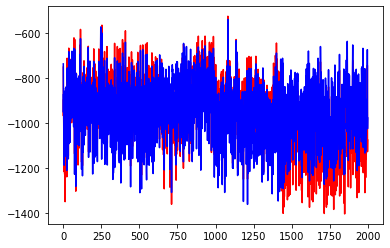

In [7]:
a = np.zeros([9,9])
a = generate_config(5)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

timesteps_count = 0  # Counting the time steps
max_steps = 24  # Maximum time steps for one episode
ep_reward_list = []
ep_reward_list_naive = []
avg_reward = -9999
agent = TD3()

for ep in range(2000):
    config = generate_config(3)
    config = config.flatten()
    episodic_reward = 0
    timestep_for_cur_episode = 0
    episodic_reward_naive = 0
    score = []

    for st in range(max_steps):
        a = np.copy(config)
        # Select action according to policy
        action = agent.policy(config.flatten())
        env = Gridworld(action)
        # Recieve state and reward from environment.
        next_config, reward = env.config_step(config)
        next_config = next_config.flatten()
        done = 0
        episodic_reward += reward
        if next_config.any() == 0:
          done = 1
        # Send the experience to the agent and train the agent
        agent.train(timesteps_count, timestep_for_cur_episode, config, action, reward, next_config, done)
        timestep_for_cur_episode += 1
        timesteps_count += 1
        
        #comparison
        action_naive = -np.zeros(16)
        env = Gridworld(action_naive)
        next_config_naive, reward_naive = env.config_step(a)
        next_config_naive = next_config_naive.flatten()
        episodic_reward_naive += reward_naive
        
        # End this episode when `done` is True
        if done:
            break
        config = next_config

    ep_reward_list.append(episodic_reward)
    ep_reward_list_naive.append(episodic_reward_naive)
    print('Ep. {}, Ep.Timesteps {}, Episode Reward: {:.2f}'.format(ep + 1, timestep_for_cur_episode, episodic_reward), end='')
    print('Ep. {}, Ep.Timesteps {}, Episode Reward_naive: {:.2f}'.format(ep + 1, timestep_for_cur_episode, episodic_reward_naive), end='')
    
    if len(ep_reward_list) == 50:
        # Mean of last 50 episodes
        avg_reward = sum(ep_reward_list) / 50
        print(', Moving Average Reward: {:.2f}'.format(avg_reward))
    else:
        print('')
print('Average reward over 50 episodes: ', avg_reward)
plt.plot(ep_reward_list,color = 'r')
plt.plot(ep_reward_list_naive, color = 'b')
print(np.mean(ep_reward_list),np.mean(ep_reward_list_naive))

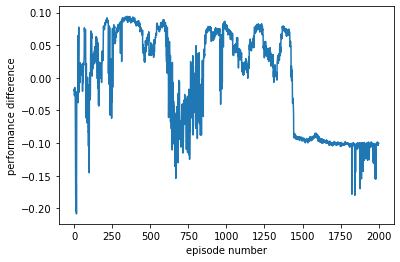

<Figure size 432x288 with 0 Axes>

In [8]:
a = -(np.array(ep_reward_list) - np.array(ep_reward_list_naive)) / ep_reward_list_naive
plt.plot(a)
plt.xlabel('episode number')
plt.ylabel('performance difference')
plt.show()
plt.savefig('final result.png')

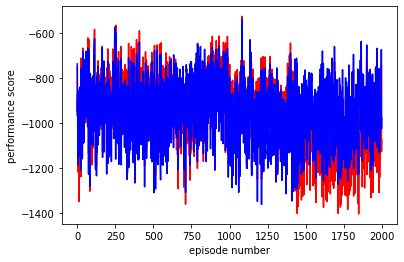

<Figure size 432x288 with 0 Axes>

In [9]:
plt.plot(ep_reward_list,color = 'r')
plt.plot(ep_reward_list_naive, color = 'b')
plt.xlabel('episode number')
plt.ylabel('performance score')
plt.show()
plt.savefig('final result 1.png')

In [38]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)
